# Handling Outliers and Basic Exploratory Analysis

***The main purpose of this project is to practice, and demonstrate knowledge of data cleaning, working with stakeholders to achieve a business objective, and data analytics***

## *Scope Overview*

1. Stakeholder wants to see trends in nighttime and daytime testing in respect to volume
2. Stakeholder wants to examine trends in subject and the amount of time used on the exam
3. Stakeholder is seeking recommendations in staffing for student-workers

## *Limitations of the Data*

*While the data covers multiple semesters, it is important to understand that this data is limited by several factors*

1. Summer 2019 was the first semester that the ODS portal was used but transitioning from an older system
2. COVID 19 - Half of the semester for Spring '20 was cancelled due to the pandemic; no exams for Summer '20; UA operated at reduced capacity for both Fall '20 and Spring '21 semesters
3. Online Exams are no longer being administered as of Fall 20 at ODS
4. Indicators (i.e., student, instructor, course number) that might reveal additional insights are protected information and cannot be used in the analysis

## *Dealing with the Limitations*

1. There might not be enough data to evaluate semester to semester data, but there is enough data to evaluate trends in week-to-week data, or evening vs. day time testing, which is an objective that our stakeholder has indicated. It is a matter of putting the data in the right context
2. The scripts used in this project can be used to load in new, more complete data as UA returns to full operations

## *Constraints*

1. '*actual_time*' values should not be zero. *Instances of this are most likely due to testing coordinator error when processing the exam in the portal*
2. '*actual_times*' that go over the '*allotted_time*' by more than 5% should be dropped. *It is likely that the testing coordinator forgot to check them out and since there is no way of knowing how long they actually took, the data can't be relied*
3. '*actual_times*' that exceeded the '*allotted_times*' but by not more than 5% should be replaced by the actual time. The '*actual_end*' should also relfect the correct time. *This is the stakeholder's preference. We are not concerned with the rate at which student's go over their allotted time, nor are concerned with process*
4. Outliers should be removed unless they can be verified
5. Night-Time testing is considered any exams that started after 16:45
6. Finals and regular semester exams should be seperated considering the massive difference in the two kinds of exams, their times, and their occurence
7. We should not include data from Spring 20 semester that resulted in an exam scheduled but cancelled due to covid

## *Notes*

When the allotted_time *cannot be verified*, it means that the instructor did not specifiy it in the ods portal. When we went to verify times for allotted_time outliers, we tried to either use the time specified on the agreement, impute with another exam in the same subject, infer based off a similiar subject, or we dropped the exam due to lack of information

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

**Load in the dataframe**

*If you wish to add a csv file, use 'Indicators_remvoed_and_basic_analysis'. You should only be loading in one file at this point*

In [2]:
file = input('Enter the name of the file without the extension: ')
finals_file = input('Enter the name of the finals semester without the extension: ')

Enter the name of the file without the extension: ods_reg_ready_3
Enter the name of the finals semester without the extension: ods_finals_ready_3


In [3]:
ods = pd.read_pickle(f'{file}.pkl')
odsFinals = pd.read_pickle(f'{finals_file}.pkl')

**Add another column that displays the day of the week**

In [4]:
ods['name_of_day'] = ods['exam_date'].dt.day_name()
odsFinals['name_of_day'] = odsFinals['exam_date'].dt.day_name()

## *Basic Summary Statistics and Outliers for Regular Semester Exams*

<AxesSubplot:>

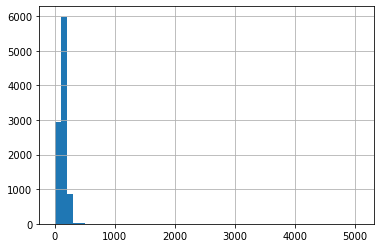

In [5]:
ods['allotted_time'].hist(bins=50)

*One obvious outlier we can get rid of is for 'allotted_time'. No student would have gotten over 3 and a half days to take an exam*

In [6]:
ods.loc[ods['allotted_time'] == 5070, ['subject', 'allotted_time', 'exam_date']]

,subject,allotted_time,exam_date
7064,ENGR,5070.0,2020-01-28
8212,ENGR,5070.0,2020-02-18
9229,ENGR,5070.0,2020-03-10
10201,ENGR,5070.0,2020-04-14
10343,ENGR,5070.0,2020-04-17


*What is the average amount of time these students got?*

In [7]:
ods.loc[(ods['subject'] == 'ENGR'), 'allotted_time'].mean()

307.7480916030534

*300 minutes is occassionally awarded in some finals, but we can see none of these dates align with final exam scheduling. We will drop these values*

**Drop the ENGR Exams with 5070 allotted time**

In [8]:
drop = ods.loc[ods['allotted_time']==5070].index
# drop = ods[ods['allotted_time']==5070].index
ods.drop(index=drop, inplace=True)

*GBA finals typically take place a week before, during dead-week. We need to move the exams to the odsFinals dataframe*

**Move GBA Finals to odsFinals dataframe**

*Since we only have one real semester of finals in our datasets (due to covid), we only need to specify one date. In future semesters, more dates will need to be specified*

*We also filter based off of 'allotted_time' since GBA finals are typically the only exams allotted those times. This is done to find make-up exams. We are more specific with exams with no extended time since 240 is a more common allotment for other exams*

In [9]:
gba_finals = ods[(ods['subject']=='GBA') & (ods['exam_date']=='2019-11-22')
                |(ods['allotted_time']==360.0)|(ods['allotted_time']==480.0)|
                (ods['allotted_time']==240.0) & (ods['subject']=='GBA')]
                 
odsFinals = pd.concat([odsFinals, gba_finals])

idx =  ods[(ods['subject']=='GBA') & (ods['exam_date']=='2019-11-22')
                | (ods['allotted_time']==360.0)|(ods['allotted_time']==480.0)|
                (ods['allotted_time']==240.0) & (ods['subject']=='GBA')].index

ods.drop(index=idx, inplace=True)

**Print out summary statistics**

count    9805.000000
mean      129.919633
std        51.075225
min         0.000000
25%       100.000000
50%       113.000000
75%       150.000000
max       750.000000
Name: allotted_time, dtype: float64


count    6720.000000
mean       78.787202
std        42.665483
min         0.000000
25%        46.000000
50%        73.000000
75%       105.000000
max       371.000000
Name: actual_time, dtype: float64


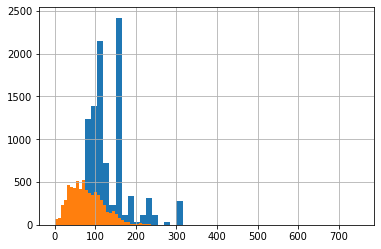

In [10]:
ods['allotted_time'].hist(bins=50)
ods['actual_time'].hist(bins=50)
print(ods['allotted_time'].describe())
print('\n')
print(ods['actual_time'].describe())

**Print out a 'box-and-whisker' plot to look at outliers**

<AxesSubplot:>

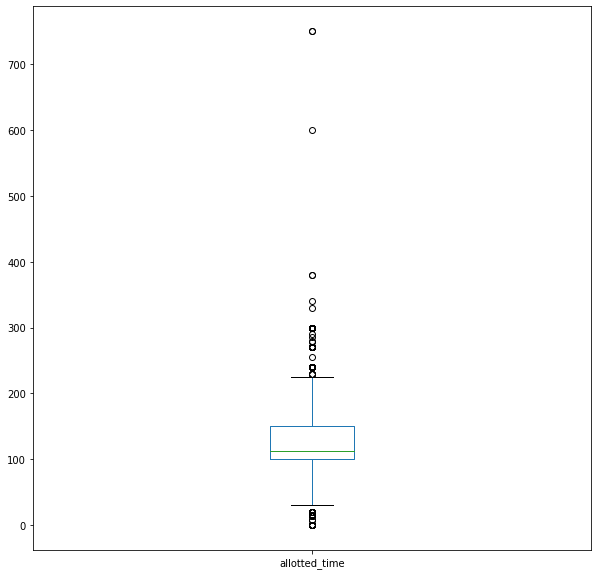

In [11]:
ods['allotted_time'].plot(kind='box', figsize=(10,10))

<AxesSubplot:>

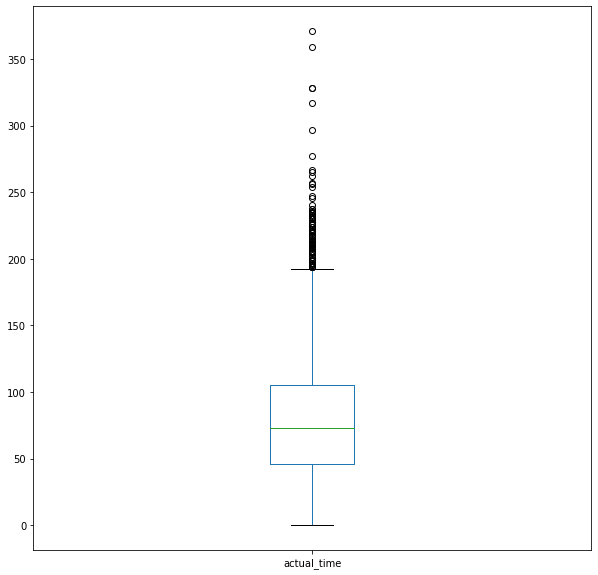

In [12]:
ods['actual_time'].plot(kind='box', figsize=(10,10))

*Regular semester exams with more than 240 minutes are rare. This was discussed with ODS director, and we both agreed that a threshold would be appropriate. The rest are treated as outliers and dropped because they are most likely due to instructor error (i.e., adding in the extra time before the system adds in the extra time)*

**Set the threshhold for 'allotted_time' to be 240**

In [13]:
ods.loc[ods['allotted_time'] > 240, ['subject', 'allotted_time', 'actual_time', 'exam_date', 'exam_cancelled', 'no_show']]

,subject,allotted_time,actual_time,exam_date,exam_cancelled,no_show
1006,KIN,300.0,45.0,2019-09-26,False,False
1007,KIN,300.0,19.0,2019-09-26,False,False
1081,APR,300.0,87.0,2019-09-26,False,False
1152,MC,270.0,83.0,2019-09-30,False,False
1158,MC,270.0,NaN,2019-09-30,True,False
...,...,...,...,...,...,...
11230,MC,300.0,NaN,2020-05-01,True,False
11232,ME,300.0,NaN,2020-05-01,True,False
11233,ME,300.0,NaN,2020-05-01,True,False
11236,AEM,270.0,NaN,2020-05-01,True,False


In [14]:
thresh=240
ods.drop(index = ods[(ods['allotted_time']>thresh) & (ods['subject']!= 'GBA')].index, inplace=True)

**Handle the lower bound of outliers**

In [15]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28,True,False,2019-10-01,No
1376,15.0,30.0,HY,28,False,False,2019-10-02,Yes
1599,0.0,NaN,GBA,6,False,True,2019-10-08,Yes
1632,20.0,NaN,CD,1,False,True,2019-10-08,No
1755,0.0,NaN,GBA,21,False,True,2019-10-09,No
2044,20.0,NaN,CD,1,False,True,2019-10-15,No
2354,15.0,20.0,HY,28,False,False,2019-10-21,Yes
2414,20.0,22.0,HY,28,False,False,2019-10-22,No
3275,20.0,39.0,CD,1,False,False,2019-11-07,No
3279,0.0,32.0,EC,4,False,False,2019-11-07,Yes


*Short quizzes that are no more than 20 mins are common. These are left in the dataframe*

*Research from the ODS Portal to find missing times and fill in values*

For Exams that have 0.0 allotted time and have null actual time values:
1. GBA exams with no time allotted and null were either incorrectly scheduled by the student, and cancelled by staff or rescheduled for another time
2. CJ exams were given online and allowed the entire day to take the exam; they did not test at ODS
3. AEM exam was cancelled
4. HES exam was cancelled
5. FI 321 exam was cancelled

*I am not sure why the system recorded the exam as zero allotted time in these instances, where it still lists the allotted time in other cancelled exams. My theory is that the exams were cancelled before they could've been approved by ODS staff. We will drop these from the dataframe*

In [16]:
ods.drop(index=ods[(ods['allotted_time'] == 0.0) & (ods['actual_time'].isna())].index, inplace=True)

**Run the code again to see what else we need to do**

In [17]:
ods.loc[ods['allotted_time']< 30, ['allotted_time', 'actual_time', 'subject', 'section','no_show', 'exam_cancelled', 'exam_date',
                                   'extra_time_1.50x']]

,allotted_time,actual_time,subject,section,no_show,exam_cancelled,exam_date,extra_time_1.50x
1265,20.0,NaN,HY,28,True,False,2019-10-01,No
1376,15.0,30.0,HY,28,False,False,2019-10-02,Yes
1632,20.0,NaN,CD,1,False,True,2019-10-08,No
2044,20.0,NaN,CD,1,False,True,2019-10-15,No
2354,15.0,20.0,HY,28,False,False,2019-10-21,Yes
2414,20.0,22.0,HY,28,False,False,2019-10-22,No
3275,20.0,39.0,CD,1,False,False,2019-11-07,No
3279,0.0,32.0,EC,4,False,False,2019-11-07,Yes
3365,15.0,21.0,HY,28,False,False,2019-11-08,Yes
4155,15.0,NaN,HY,28,True,False,2019-11-22,Yes


*Now, we can fill in the '0.0' for allotted times where an actual time was recorded for that subject on the same day. We need to research the portal to do this*

**Drop rows that have no values to reference**

*7237 has no reference in the portal, so we can drop that record*

In [18]:
ods.drop(index=7237,inplace=True)

**Fill in the missing allotted time for EC with 113**

In [19]:
ods.loc[3279, ['allotted_time']]=113.0
ods.loc[4172, ['allotted_time']]=360.0
ods.loc[7229, ['allotted_time']]=75.0
ods.loc[8854, ['allotted_time']]=120.0

## Handle Actual Time Outliers

*We use 194 because that is the upper bound of the IQR*

In [20]:
ods.loc[ods['actual_time'] > 194, ['subject', 'section', 'allotted_time', 'actual_time', 'exam_date']]

,subject,section,allotted_time,actual_time,exam_date
394,PY,1.0,150.0,198.0,2019-09-17
411,CH,1.0,120.0,199.0,2019-09-17
418,FI,320.0,150.0,213.0,2019-09-17
613,AEM,4.0,240.0,215.0,2019-09-19
734,CE,1.0,240.0,234.0,2019-09-23
...,...,...,...,...,...
9111,BSC,4.0,220.0,210.0,2020-03-09
9122,BSC,9.0,220.0,195.0,2020-03-09
9183,MKT,1.0,240.0,267.0,2020-03-10
9361,CH,2.0,203.0,204.0,2020-03-11


*We should try and fill in actual_times that went over allotted times with the allotted time value. Stakeholder is not concerned with the rate of which students are not finishing when they're supposed to. However, data in which the student went significantly over the allotted amount time should be dropped because there is no way to verify when the student actually finished. It is possible (and has happened) where a student finished well before their allotted time but was not checked out until hours later. We should set a threshold in which all exams exceeding that threshold should be dropped*

**Drop all exams that went over the threshold. For exams that aren't over the threshold, set the actual end and actual time to end time and allotted time, respectively**

In [21]:
allot_thresh = ods['allotted_time'] + (ods['allotted_time']*0.05)
allot_indx = ods.loc[ods['actual_time'] > allot_thresh].index
ods.drop(index=allot_indx, inplace=True)
idx = ods.loc[ods['actual_time'] > ods['allotted_time']].index
ods.loc[idx, ['actual_end']] = ods['end_time']
ods.loc[idx, ['actual_time']] = ods['allotted_time']

In [22]:
ods.loc[ods['actual_time'] > 194, ['subject', 'section', 'allotted_time', 'actual_time', 'exam_date', 'start_time', 'end_time']]

,subject,section,allotted_time,actual_time,exam_date,start_time,end_time
613,AEM,4.0,240.0,215.0,2019-09-19,16:30:00,20:30:00
734,CE,1.0,240.0,234.0,2019-09-23,15:00:00,19:00:00
1048,AC,3.0,240.0,195.0,2019-09-26,12:30:00,16:30:00
1382,CHE,1.0,240.0,230.0,2019-10-02,17:00:00,21:00:00
1523,MIS,1.0,220.0,212.0,2019-10-04,13:00:00,16:40:00
1625,CTD,2.0,220.0,210.0,2019-10-08,12:50:00,16:30:00
1743,CS,910.0,240.0,240.0,2019-10-09,14:00:00,18:00:00
2291,AEM,4.0,240.0,211.0,2019-10-17,18:00:00,22:00:00
2292,AEM,4.0,240.0,240.0,2019-10-17,18:00:00,22:00:00
3641,AEM,4.0,240.0,237.0,2019-11-14,18:00:00,22:00:00


## Drop Exams after 03/13/2020, but before 09/01/2020

*These exams were scheduled before covid but never took place*

In [23]:
ods.loc[(ods['exam_date'] > '2020-03-13') & (ods['exam_date']< '2020-09-01')]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
9551,BSC,4.0,2020-03-23,Unspecified,04,15:30:00,18:53:00,15:30:00,18:53:00,2020-01-13 11:39:00,...,No,No,No,No,203.0,NaN,True,False,70.0,Monday
9552,CJ,900.0,2020-03-23,Unspecified,Scribe,17:30:00,19:30:00,17:30:00,19:30:00,2020-01-15 11:21:00,...,Yes,No,Yes,Yes,120.0,NaN,True,False,68.0,Monday
9553,MTE,998.0,2020-03-23,Unspecified,02,17:30:00,19:45:00,17:30:00,19:45:00,2020-01-16 21:24:00,...,No,No,No,No,135.0,NaN,True,False,67.0,Monday
9554,BSC,920.0,2020-03-24,Unspecified,03,10:00:00,12:15:00,10:00:00,12:15:00,2020-02-07 12:22:00,...,No,No,No,No,135.0,NaN,True,False,46.0,Tuesday
9555,ECE,1.0,2020-03-24,Unspecified,06,11:00:00,13:30:00,11:00:00,13:30:00,2020-01-17 10:25:00,...,Yes,No,No,No,150.0,NaN,True,False,67.0,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11231,MC,1.0,2020-05-01,Unspecified,15,11:30:00,15:15:00,11:30:00,15:15:00,2020-01-09 21:19:00,...,No,No,No,No,225.0,NaN,True,False,113.0,Friday
11234,PSC,1.0,2020-05-01,Unspecified,Not Specified,11:30:00,15:15:00,11:30:00,15:15:00,2020-01-26 18:09:00,...,No,No,No,No,225.0,NaN,True,False,96.0,Friday
11235,PSC,1.0,2020-05-01,Unspecified,04,11:30:00,15:15:00,11:30:00,15:15:00,2020-01-08 13:25:00,...,No,No,No,No,225.0,NaN,True,False,114.0,Friday
11237,MC,1.0,2020-05-05,Unspecified,01,12:30:00,14:23:00,12:30:00,14:23:00,2020-02-29 23:12:00,...,No,No,Yes,No,113.0,NaN,True,False,66.0,Tuesday


In [24]:
odsFinals.loc[(odsFinals['exam_date'] > '2020-03-13') & (odsFinals['exam_date']< '2020-09-01')]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
10347,GBA,5,2020-04-17,Unspecified,23,09:00:00,17:00:00,09:00:00,17:00:00,2020-02-18 13:01:00,...,Yes,No,No,No,480.0,NaN,True,False,59.0,Friday
10367,GBA,4,2020-04-17,Unspecified,01,10:00:00,18:00:00,10:00:00,18:00:00,2020-01-09 12:23:00,...,Yes,No,No,No,480.0,NaN,True,False,99.0,Friday
10368,GBA,7,2020-04-17,Unspecified,03,10:00:00,18:00:00,10:00:00,18:00:00,2020-01-10 13:47:00,...,Yes,No,No,No,480.0,NaN,True,False,98.0,Friday
10373,GBA,12,2020-04-17,Unspecified,22,11:00:00,15:00:00,11:00:00,15:00:00,2020-02-18 12:36:00,...,No,No,No,No,240.0,NaN,True,False,59.0,Friday
10418,GBA,12,2020-04-22,Unspecified,03,14:00:00,22:00:00,14:00:00,22:00:00,2020-01-28 17:20:00,...,Yes,No,No,No,480.0,NaN,True,False,85.0,Wednesday
11224,HD,3,2020-05-01,Unspecified,Not Specified,11:30:00,17:30:00,11:30:00,17:30:00,2020-02-18 13:49:00,...,Yes,No,No,No,360.0,NaN,True,False,73.0,Friday


In [25]:
idx = ods.loc[(ods['exam_date'] > '2020-03-13') & (ods['exam_date']< '2020-09-01')].index
finals_idx = odsFinals.loc[(odsFinals['exam_date'] > '2020-03-13') & (odsFinals['exam_date']< '2020-09-01')].index

In [26]:
ods.drop(index=idx, inplace=True)

In [27]:
odsFinals.drop(index=finals_idx, inplace=True)

## Finals Cleaning

<AxesSubplot:>

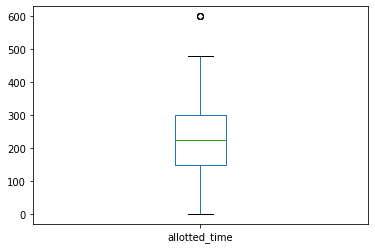

In [28]:
odsFinals['allotted_time'].plot(kind='box')

<AxesSubplot:>

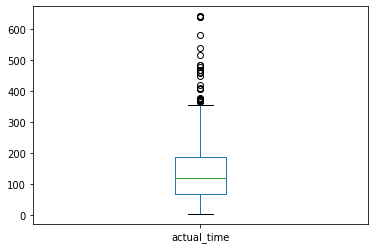

In [29]:
odsFinals['actual_time'].plot(kind='box')

*We need to identify the outliers for both of these variables*

**allotted time**

In [30]:
odsFinals.loc[odsFinals['allotted_time'] > 500]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
0,AEM,100,2019-08-01,Bulls,05,08:00:00,18:00:00,08:00:00,18:00:00,2019-07-23 11:26:00,...,No,No,No,No,600.0,NaN,False,True,9.0,Thursday
12,ECE,150,2019-08-01,Bulls,18,08:00:00,18:00:00,08:24:00,12:48:00,2019-07-31 10:41:00,...,No,No,No,No,600.0,264.0,False,False,1.0,Thursday
43,KIN,100,2019-08-02,Bulls,19,08:00:00,18:00:00,08:14:00,08:38:00,2019-08-01 08:47:00,...,No,No,No,No,600.0,24.0,False,False,1.0,Friday
411,HY,28,2019-12-10,Bulls,46,13:00:00,23:00:00,13:00:00,16:28:00,2019-12-06 17:04:00,...,Yes,No,No,Yes,600.0,208.0,False,False,4.0,Tuesday


Descriptions for the above frame
1. AEM should've been awarded 300 minutes. 600 minutes is 10 hours. GBA exams with 2.0x don't even get this much time. This is likely due to the instructor preemptively adding in the extra time
2. ECE cannot be verified but it is extremely unlikely that the student was awarded this much time. Other finals in the same subject but different course got 300 minutes with 2.0x time. 
3. The same can be said for KIN and HY

**Drop these exams**

In [31]:
index = odsFinals.loc[odsFinals['allotted_time'] > 500].index
odsFinals.drop(index=index, inplace=True)

**actual time**

In [32]:
odsFinals.loc[odsFinals['actual_time']> 375]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
288,ECE,1,2019-12-10,Bulls,33,08:00:00,13:00:00,08:00:00,16:59:00,2019-12-06 07:41:00,...,Yes,No,No,No,300.0,539.0,False,False,4.0,Tuesday
307,ME,2,2019-12-10,Bulls,Virtual Room (Finals Only),08:00:00,13:00:00,08:00:00,16:37:00,2019-09-26 16:33:00,...,Yes,No,No,No,300.0,517.0,False,False,75.0,Tuesday
322,HD,1,2019-12-10,Unspecified,Virtual Room (Finals Only),08:05:00,14:05:00,08:05:00,17:47:00,2019-09-05 15:27:00,...,Yes,No,No,No,360.0,582.0,False,False,96.0,Tuesday
348,CS,1,2019-12-10,Bulls,32,10:00:00,14:00:00,10:00:00,16:59:00,2019-09-16 13:05:00,...,Yes,Yes,No,No,240.0,419.0,False,False,85.0,Tuesday
356,GN,1,2019-12-10,Unspecified,11,10:00:00,14:00:00,10:00:00,17:48:00,2019-10-28 14:25:00,...,Yes,No,No,No,240.0,468.0,False,False,43.0,Tuesday
358,HY,32,2019-12-10,Bulls,13,10:00:00,11:15:00,10:00:00,17:48:00,2019-09-26 12:39:00,...,No,No,No,No,75.0,468.0,False,False,75.0,Tuesday
618,EN,14,2019-12-11,Bulls,30,10:00:00,15:00:00,10:02:00,20:41:00,2019-09-10 07:41:00,...,Yes,No,No,No,300.0,639.0,False,False,92.0,Wednesday
620,FI,322,2019-12-11,Bulls,33,10:00:00,13:45:00,10:00:00,20:42:00,2019-10-18 13:46:00,...,No,No,No,No,225.0,642.0,False,False,54.0,Wednesday
622,HY,1,2019-12-11,Unspecified,Virtual Room (Finals Only),10:00:00,15:00:00,10:00:00,20:42:00,2019-08-23 21:40:00,...,Yes,No,No,No,300.0,642.0,False,False,110.0,Wednesday
637,ST,2,2019-12-11,Bulls,48,10:00:00,13:45:00,10:00:00,20:41:00,2019-08-23 14:37:00,...,No,No,No,No,225.0,641.0,False,False,110.0,Wednesday


**Drop exams over the threshold. Then set the remaining rows to the value of allotted time and end time**

In [33]:
allot_thresh = odsFinals['allotted_time'] + (odsFinals['allotted_time']*0.05)
idx = odsFinals.loc[odsFinals['actual_time'] > allot_thresh].index
odsFinals.drop(idx, inplace=True)
idx = odsFinals[odsFinals['actual_time'] > odsFinals['allotted_time']].index
odsFinals.loc[idx, ['actual_end']] = odsFinals['end_time']
odsFinals.loc[idx, ['actual_time']] = odsFinals['allotted_time']

<AxesSubplot:>

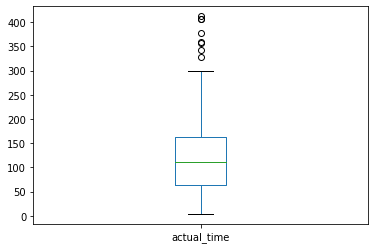

In [34]:
odsFinals['actual_time'].plot(kind='box')

*Most of the remaining outliers in the box-and-whisker plot above are GBA finals, which are accurate*

In [35]:
odsFinals.loc[odsFinals['actual_time']>=330, ['subject', 'allotted_time', 'actual_time', 'exam_date']]

,subject,allotted_time,actual_time,exam_date
724,RHM,360.0,342.0,2019-12-11
4088,GBA,480.0,412.0,2019-11-22
4107,GBA,480.0,377.0,2019-11-22
4108,GBA,480.0,406.0,2019-11-22
4131,GBA,360.0,360.0,2019-11-22
4135,GBA,480.0,407.0,2019-11-22
4151,GBA,360.0,356.0,2019-11-22


*RHM's allotted_time cannot be verified. It should be dropped*

In [36]:
odsFinals.drop(index=724, inplace=True)

*We need to handle exams that have no actual time. These were completed exams but not properly entered into the portal. They were simply marked 'Complete'. We should drop these so that are data is represented accurately*

In [37]:
ods[ods['actual_time']==0.0]

,subject,section,exam_date,proctor,room_number,start_time,end_time,actual_start,actual_end,first_entered,...,extra_time_2.00x,makeup_accommodation,noScantronExam,readerForExams,allotted_time,actual_time,exam_cancelled,no_show,days_requested_submitted_in_advance,name_of_day
376,CD,1.0,2019-09-17,Bulls,42,13:00:00,14:53:00,13:29:00,13:29:00,2019-09-10 13:12:00,...,No,No,No,No,113.0,0.0,False,False,7.0,Tuesday
710,EN,4.0,2019-09-23,Bulls,45,12:00:00,13:15:00,13:03:00,13:03:00,2019-09-09 14:01:00,...,No,No,No,No,75.0,0.0,False,False,14.0,Monday
1001,LGS,336.0,2019-09-25,Unspecified,Not Specified,18:30:00,20:23:00,17:54:00,17:54:00,2019-09-25 17:53:00,...,No,No,No,No,113.0,0.0,False,False,0.0,Wednesday
1274,PY,10.0,2019-10-01,Vanslambrouck,48,14:00:00,15:53:00,14:42:00,14:42:00,2019-09-01 15:52:00,...,No,No,No,No,113.0,0.0,False,False,30.0,Tuesday
1277,RHM,1.0,2019-10-01,Vanslambrouck,14,14:00:00,15:40:00,14:20:00,14:20:00,2019-09-05 17:18:00,...,Yes,No,No,No,100.0,0.0,False,False,26.0,Tuesday
1630,MKT,5.0,2019-10-08,Bulls,13,14:00:00,15:53:00,14:37:00,14:37:00,2019-09-10 11:23:00,...,No,No,No,No,113.0,0.0,False,False,28.0,Tuesday
1720,PY,2.0,2019-10-09,Bulls,48,10:00:00,11:40:00,11:02:00,11:02:00,2019-09-04 14:29:00,...,Yes,Yes,No,No,100.0,0.0,False,False,35.0,Wednesday
1817,KIN,1.0,2019-10-10,Bulls,Scribe,11:00:00,12:53:00,13:30:00,13:30:00,2019-10-04 11:11:00,...,No,No,Yes,No,113.0,0.0,False,False,6.0,Thursday
2060,EC,1.0,2019-10-15,Vanslambrouck,03,16:00:00,17:53:00,16:28:00,16:28:00,2019-09-05 13:50:00,...,No,No,No,No,113.0,0.0,False,False,40.0,Tuesday
2125,RHM,2.0,2019-10-16,Bulls,07,11:00:00,12:15:00,11:24:00,11:24:00,2019-10-14 11:59:00,...,No,No,No,No,75.0,0.0,False,False,2.0,Wednesday


In [38]:
index = ods[ods['actual_time']==0.0].index

ods.drop(index=index, inplace=True)

## Double Checking DataFrames before Exporting

In [39]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7358 entries, 0 to 4172
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              7357 non-null   object        
 1   section                              7357 non-null   float64       
 2   exam_date                            7357 non-null   datetime64[ns]
 3   proctor                              7357 non-null   object        
 4   room_number                          7357 non-null   string        
 5   start_time                           7357 non-null   object        
 6   end_time                             7357 non-null   object        
 7   actual_start                         7357 non-null   object        
 8   actual_end                           7357 non-null   object        
 9   first_entered                        7357 non-null   datetime64[ns]
 10  fileUploaded

*We have a null at 4172*

**Drop the null value at index 4172**

In [40]:
ods.drop(index=4172, inplace=True)

In [41]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7357 entries, 0 to 9550
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              7357 non-null   object        
 1   section                              7357 non-null   float64       
 2   exam_date                            7357 non-null   datetime64[ns]
 3   proctor                              7357 non-null   object        
 4   room_number                          7357 non-null   string        
 5   start_time                           7357 non-null   object        
 6   end_time                             7357 non-null   object        
 7   actual_start                         7357 non-null   object        
 8   actual_end                           7357 non-null   object        
 9   first_entered                        7357 non-null   datetime64[ns]
 10  fileUploaded

In [45]:
odsFinals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1290 entries, 1 to 6467
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   subject                              1290 non-null   object        
 1   section                              1290 non-null   int64         
 2   exam_date                            1290 non-null   datetime64[ns]
 3   proctor                              1290 non-null   object        
 4   room_number                          1290 non-null   string        
 5   start_time                           1290 non-null   object        
 6   end_time                             1290 non-null   object        
 7   actual_start                         1290 non-null   object        
 8   actual_end                           1290 non-null   object        
 9   first_entered                        1290 non-null   datetime64[ns]
 10  fileUploaded

## Exporting for PostgreSQL and Pickle

In [44]:
ods.to_csv('PostgrExReg071021.csv')
odsFinals.to_csv('PostgrExFinals071021.csv')
ods.to_pickle('pickled_cleaned_reg_exams.pkl')
odsFinals.to_pickle('pickled_cleaned_finals_exams.pkl')